# Monophonic pitch detection with the Harmonic Product Spectrum (HPS) algorithm

## Introduction
For musical signals the spectrum consists of a series of peaks corresponding to a fundamental frequency with harmonic components, called _partials_, positioned at integer multiples of the fundamental. Thus, by downsampling a spectrum several times the strongest harmonic peaks should line up. 

For example, by downsampling a spectrum by a factor of two, the second peak in the resulting spectrum will line up with the fundamental. Likewise, the third peak in a spectrum compressed by a factor of three will line up with the fundamental, and so on. Therefore, if the spectra are multiplied per bin, each product will be small for all frequencies except at the position that corresponds to the fundamental frequency. This downsampling technique could therefore be used to estimate pitch in monophonic musical signals, and this is the key idea of HPS.

## Beware
Two caveats are that we're relying on instruments to have harmonic spectrums. This is not always the case. For example, inharmonicity caused by string tension means some instruments have displaced partials over a slightly stretched harmonic series. Piano particularly so, due to very high string tension. Similarly, the human voice doesn't follow a particular harmonic series, but rather has formants that cause us to perceive different vowels. Additionally, certain instruments have vastly different magnitudes at specific partial intervals, such as the clarinet or saxophone, which is what makes up their particular acoustic sound, or _timbre_. 

Thus, for HPS to work, we're relying on all partial's magnitudes to be non-zero, because otherwise the product turns very small and the resulting peak might not be clearly spotted. So as a monophonic pitch detection method, HPS should work well for violins and worse for vocals and piano, for which we'd might want to look to autocorrelation instead.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import librosa as lr
from librosa.display import waveplot, specshow
from pysndfx import AudioEffectsChain

%matplotlib inline

In [2]:
# Load audio with LibROSA.
y, sr = lr.load('violin.wav', None)

In [5]:
def pitch_hps(audio_samples,
              sample_rate=sr,
              window_length=4096,
              hop_length=1024,
              window=np.hanning,
              partials=5,
              plot=False):
    """Estimate the pitch contour in a monophonic audio signal."""

    f0s = []
    frequencies = np.fft.rfftfreq(window_length, 1 / sample_rate)
    window = window(window_length)
    pad = lambda a: np.pad(a, 
                           (0, window_length - len(a)),
                           mode='constant',
                           constant_values=0)
    
    # Low cut filter audio at 50 Hz.
    audio_samples = AudioEffectsChain().highpass(50)(audio_samples)

    # Go through audio frame-by-frame.
    for i in range(0, len(audio_samples), hop_length):

        # Fourier transform audio frame.

        frame = window * pad(audio_samples[i:window_length + i])
        spectrum = np.fft.rfft(frame)

        # Downsample spectrum.
        spectra = []
        for n in range(1, partials + 1):
            s = sp.signal.resample(spectrum, len(spectrum) // n)
            spectra.append(s)

        # Truncate to most downsampled spectrum.
        l = min(len(s) for s in spectra)
        a = np.zeros((len(spectra), l), dtype=spectrum.dtype)
        for i, s in enumerate(spectra):
            a[i] += s[:l]

        # Multiply spectra per frequency bin.
        hps = np.product(np.abs(a), axis=0)

        # TODO Blur spectrum to remove noise and high-frequency content.
        #kernel = sp.signal.gaussian(9, 1)
        #hps = sp.signal.fftconvolve(hps, kernel, mode='same')

        # TODO Detect peaks with a continuous wavelet transform for polyphonic signals.
        #peaks = sp.signal.find_peaks_cwt(np.abs(hps), np.arange(1, 3))

        # Pick largest peak, it's likely f0.
        peak = np.argmax(hps)
        f0 = frequencies[peak]
        f0s.append(f0)

        if plot:

            # Plot partial magnitudes individually.
            for s, ax in zip(spectra,
                             plt.subplots(len(spectra), sharex=True)[1]):
                ax.plot(np.abs(s))
            plt.suptitle('Partials')
            plt.show()

            # Plot combined spectra.
            plt.imshow(np.log(np.abs(a)), aspect='auto')
            plt.title('Spectra')
            plt.colorbar()
            plt.show()

            # Plot HPS peak.
            plt.plot(np.arange(len(hps)), np.abs(hps))
            plt.scatter(peak, np.abs(hps[peak]), color='r')
            plt.title('HPS peak')
            plt.show()
            return

    f0s = np.array(f0s)

    # Median filter out noise.
    f0s = sp.signal.medfilt(f0s, [21])

    return f0s

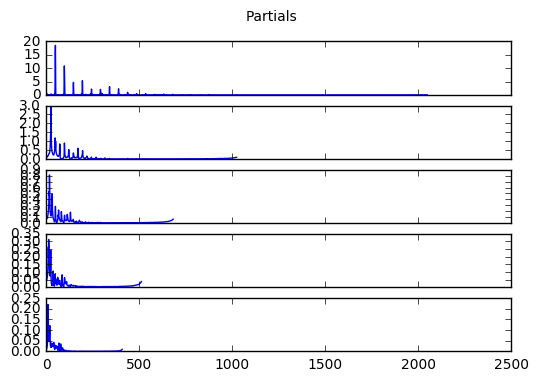

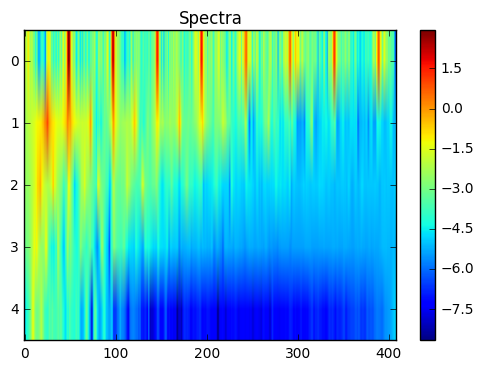

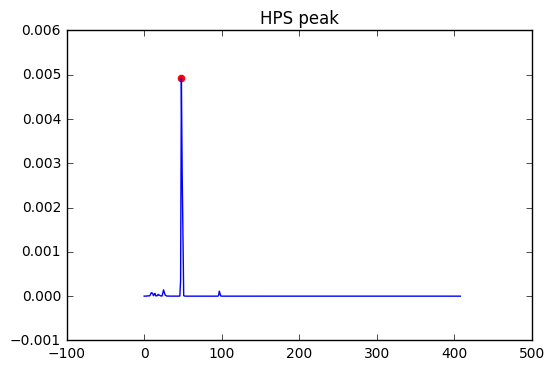

In [4]:
pitch_hps(y, plot=True)

In [6]:
%%time
f0s = pitch_hps(y)

CPU times: user 6.54 s, sys: 16 ms, total: 6.56 s
Wall time: 6.58 s


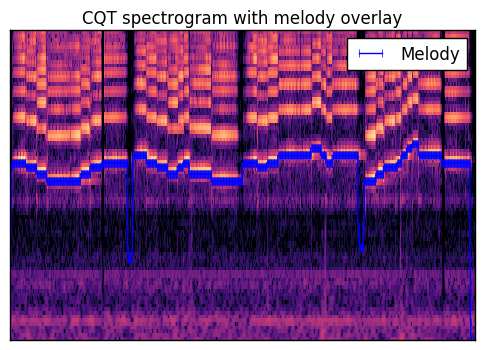

In [7]:
specshow(lr.logamplitude(np.abs(lr.cqt(y, hop_length=1024, sr=sr))**2))
notes = lr.hz_to_midi(f0s + np.finfo(float).eps).round()
plt.step(np.arange(len(f0s)), 
         notes - lr.note_to_midi('C1'), 
         marker='|',
         label='Melody')
plt.title('CQT spectrogram with melody overlay')
plt.legend();